# Classification with 2-dimensional input

We will implememt classification with GPs on multivariate input. 

### Scientific value:

In practice, it is hard to use GPs for classification because this requires the transformation of the GP output via a sigmoid function (or something similar).
This has the effect that a non-Gaussian likelihood has to be optimized (or a posterior inferred ) - which is hard.


### Deliverables

What currently does not work is gradient-based inference and multivariate input for GPs. For now, we only need to ensure that a GP can process input in  form of:

- scalars;

- 1- d arrays (to model vectors);

- multi-dimensional arrays (to model matrices);

a) **Multivariate input GPs.**

In the future, we should allow GPs to cope with all kinds of input that can be used for a covariance function. For now, we only focus on the three above.

=> Who is delivering this? Ulli with Taylor's help.


b) **Gradient-based inference.** For now, gradient ascent inference is sufficient.

=> Who is delivering this? Taylor with Ulli's help.


### Goal

Show that the posterior distribution of classes (Fig. 3, below) moves from the prior (Fig. 2) and clearly models the distribution of classes over the input space (e.g. similar to Fig. 4) as given by the training data (Fig. 1).  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import codecs
import matplotlib.pyplot as plt
%matplotlib inline  

from venture import shortcuts

# Generate Training and Test Data

We synthetically generate some training and some test data. The details of this are not important. Important is that the training data is depicted in Fig. 1 below.

The number of training data

In [2]:
n = 30

Number of test data

In [3]:
n_test = 200

helper functions & data generator

In [4]:
demarcation_function = lambda x: x**4 - 2*x**2 + x
plotting_points = np.linspace(-2,2,500)
data_x = np.random.uniform(-2,2,n+n_test)
data_y = np.random.uniform(-5,9,n+n_test)
all_labels = []
for i,point in enumerate(data_y):
    if demarcation_function(data_x[i])>point:
        all_labels.append(1)
    else:
        all_labels.append(0)

### Training data & test data

In [5]:
training_data_x = data_x[0:n]
training_data_y = data_y[0:n]
training_labels = all_labels[0:n]

test_data_x = data_x[0:(n+n_test)]
test_data_y = data_y[0:(n+n_test)]
test_labels = all_labels[0:n]

### Plot the training data and the demarcation line

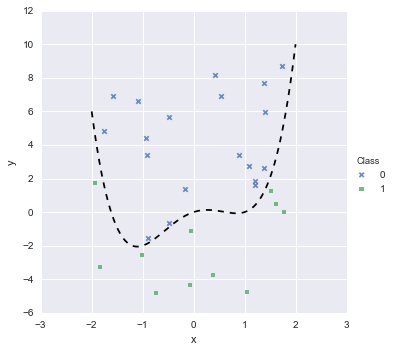

In [6]:
df = pd.DataFrame({"x":training_data_x, "y":training_data_y, "Class":training_labels})
sns.lmplot("x", "y", data=df, hue='Class', markers =["x","s"], fit_reg=False)
plt.plot(plotting_points,demarcation_function(plotting_points),c = 'k',linestyle="--")
xmin,xmax,ymin,ymax = plt.axis()

Fig. 1: Training data. Blue x mark class 0, green squares mark class 1.

# The Venture Program

In [7]:
ripl = shortcuts.make_lite_ripl()

Couldn't import dot_parser, loading of dot files will not be possible.


Below, we implement the **hyper-parameters** and **covariance and mean functions**.

In [8]:
program_part_1 = """

// Hyper-parameters

assume tolerance_constant = 00000.1;

assume noise_sigma = tag("hyper", 0, gamma(5, 1));

assume scale_factor = tag("hyper", 1, gamma(5, 1));
assume length_scale = tag("hyper", 2, gamma(5, 1));



// Covariance Function
assume noise_kernel = gp_cov_scale(noise_sigma,
                                   gp_cov_delta(tolerance_constant)
                                );
                                   
assume se_kernel = gp_cov_scale(scale_factor,
                                gp_cov_se(length_scale)
                                );

assume covariance_kernel = gp_cov_sum(se_kernel, noise_kernel);

assume zero_mean_function =gp_mean_const(0.);
"""
ripl.execute_program(program_part_1);

We define a `fake_gp`- which ignores input covariance function and mean function and outputs a sample from a multivariate normal where the length of the sample is determined by the input to `fake_gp`. We do this because currently, multivariate input breaks the GP implementation - thus we stub the actual gp ( `make_gp` ) to generate plots and results. 

In [9]:
program_part_2 = """
assume fake_gp = proc(mean_function, covariance_function){
    proc(x,y){
        zeros = fill(size(x), 0);
        ones  = fill(size(x), 1);
        
        multivariate_normal(zeros,diag_matrix(ones))    
    }
};
"""
ripl.execute_program(program_part_2);

We call this "fake-GP" instead of make_gp. We also define the **sigmoid function** that provides a mapping from real-valued output into probability space. Further, we define an observation function that maps the GP output with this.

In [10]:
program_part_3 = """
// FIXME - why does this throw error when I write exp( - x ) instead
assume sigmoid = proc(x){
    1./(1. + exp(0 - x ))
    };


// GP
assume gp = fake_gp(zero_mean_function, covariance_kernel);


// Observation Function
assume observation_function = proc(x, y){
    probability = sigmoid(
                        lookup(
                                gp(array(x), array(y)),
                                0)
                        );
    bernoulli(probability)
    };
"""
ripl.execute_program(program_part_3);

# Sample from the Prior

We take samples from both the transformed GP-prior and the hyper-priors. We start by initializing lists that we deploy to later visualize the hyper-prior (Fig. 5). We plot a contour plot from the prior - blue and green contours correspond to the classes as in Fig. 1. The two distribution overlay since no inference was performed and no observations made.

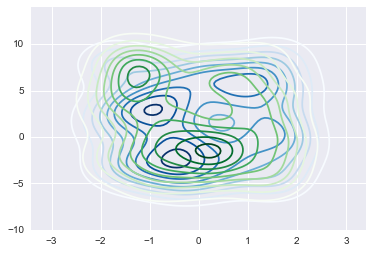

In [11]:
prior_labels = []
prior_length_scale = []
prior_scale_factor = []
prior_noise_sigma = []
for i in range(test_data_x.shape[0]):
    ripl.infer("reset_to_prior")
    prior_labels.append(ripl.sample("observation_function(%d, %d)"  % (test_data_x[i],test_data_y[i],)))
    prior_noise_sigma.append(ripl.sample("noise_sigma")) 
    prior_length_scale.append(ripl.sample("length_scale"))
    prior_scale_factor.append(ripl.sample("scale_factor"))

prior_labels = np.array(prior_labels)
ax = sns.kdeplot(np.array(test_data_x[prior_labels==0]), test_data_y[prior_labels==0],
                  cmap="Blues",  n_levels=10,  shade_lowest=False)
ax = sns.kdeplot(np.array(test_data_x[prior_labels==1]), test_data_y[prior_labels==1],
                  cmap="Greens", n_levels=10, shade_lowest=False)

Fig.2: Prior distribution of class assignements of points over the input space.

# Make Observations

In [12]:
for i,x in enumerate(training_data_x):
    ripl.observe("observation_function(%d, %d)"  % (training_data_x[i],training_data_y[i],), training_labels[i])

## Inference

At this stage, I cannot tell whether or not MH-hyperparameter inference is working because I do not know whether the posterior is different from the prior in a meaningful way. Finally, we will have to use Marco's framework to test this. Note that the literature (e.g. Neals work on MCMC for GPs) that MH does not do a good job here and that one needs a more sophisticated inference scheme (I think Neal uses HMC with Slice).

In [13]:
ripl.infer("""mh("hyper", one, 100)""")

[7.33]

## What we need to get to run 

Here is one of the goals - get the statement below to run and perform reasonable inference.

In [14]:
#ripl.infer("grad_ascent(default, all, 0.05, 100, 1)")

# Samples from Posterior

We take samples from both the transformed GP-posterior and the hyper-posterior. We start by initializing lists that we later deploy to visualize hyper-posterior (Fig. 6). We plot a contour plot from the prior - blue and green contours correspond to the classes as in Fig. 1. The two distribution overlay since  we use a fake GP that ignorese inference. Therefore, no meaningful inference was performed and no observations were actually incorporated.

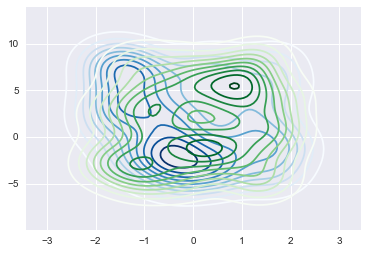

In [15]:
posterior_labels = []
posterior_length_scale = []
posterior_scale_factor = []
posterior_noise_sigma = []
for i in range(test_data_x.shape[0]):
    posterior_labels.append(ripl.sample("observation_function(%d, %d)"  % (test_data_x[i],test_data_y[i],)))
    ripl.infer("""mh("hyper", 0, 1)""")
    posterior_noise_sigma.append(ripl.sample("noise_sigma"))
    ripl.infer("""mh("hyper", 1, 1)""")
    posterior_length_scale.append(ripl.sample("length_scale"))
    ripl.infer("""mh("hyper", 2, 1)""")
    posterior_scale_factor.append(ripl.sample("scale_factor"))
    
    
posterior_labels = np.array(posterior_labels)
ax = sns.kdeplot(np.array(test_data_x[posterior_labels==0]), test_data_y[posterior_labels==0],
                  cmap="Blues",  n_levels=10,  shade_lowest=False)
ax = sns.kdeplot(np.array(test_data_x[posterior_labels==1]), test_data_y[posterior_labels==1],
                  cmap="Greens", n_levels=10, shade_lowest=False)

Fig.3: Posterior distribution of class assignements of points over the input space.

## The above is stubbed and wrong - The plot should roughly look like this (please ignore the bad code quality of this):
The sole purpose of this is to draw something that looks like a reasonable posterior.

(-6.0, 12.0)

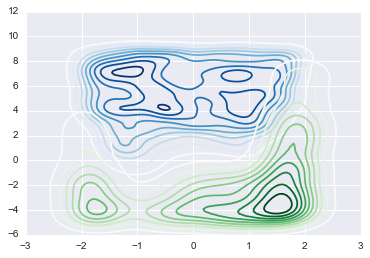

In [16]:
# hacky code simulating how the plot above should actually look like:
x_samples = np.random.uniform(-2,2,5000)
y_samples = np.random.uniform(-5,9,5000)
x_false = []
y_false = []
x_true = []
y_true = []
for i,y_sample in enumerate(y_samples):
    if demarcation_function(x_samples[i]) > y_sample:
        if np.random.uniform(0,1) < (abs(y_sample - demarcation_function(x_samples[i])))/abs(abs(demarcation_function(x_samples[i]) - 7)):
            x_true.append(x_samples[i])
            y_true.append(y_sample)
    else:
        if np.random.uniform(0,1) < (abs(y_sample - demarcation_function(x_samples[i])))/abs(abs(demarcation_function(x_samples[i]) - 4)):            
            x_false.append(x_samples[i])
            y_false.append(y_sample)     
ax = sns.kdeplot(np.array(x_false), np.array(y_false),
                  cmap="Blues",  n_levels=10,  shade_lowest=False)
ax = sns.kdeplot(np.array(x_true), np.array(y_true),
                  cmap="Greens", n_levels=10, shade_lowest=False)
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])

Fig. 4: How a good posterior could look like. The posterior clearly corresponds to the classes of the training data.
    (Fig. 1)

# Shift of Hyperprior to Hyperposterior

We perform hyper-parameter inference. Thus, it makes sense to show the change of the distribution of hyper-parameters.

### Hyperprior

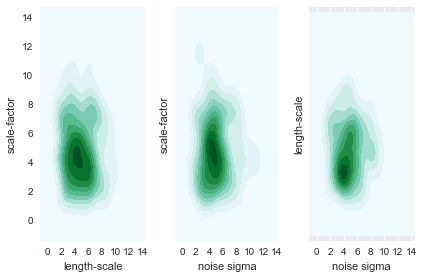

In [17]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
sns.kdeplot(np.array(prior_length_scale), np.array(prior_scale_factor), shade=True, ax=axes[0])
sns.kdeplot(np.array(prior_noise_sigma), np.array(prior_scale_factor), shade=True, ax=axes[1])
sns.kdeplot(np.array(prior_noise_sigma), np.array(prior_length_scale), shade=True, ax=axes[2])
axes[0].set_xlabel('length-scale')
axes[0].set_ylabel('scale-factor')
axes[1].set_xlabel('noise sigma')
axes[1].set_ylabel('scale-factor')
axes[2].set_xlabel('noise sigma')
axes[2].set_ylabel('length-scale')
fig.tight_layout()

Fig. 5: Hyper-prior. We sample from the Hyperparameter - prior; no data has been observed and no hyper-parameter inference was performed. That is we do not condition on observed input output relationships and deploy the prior samples of the hyper-parameters.

### Hyperposterior

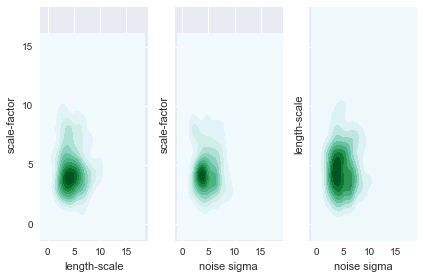

In [18]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
sns.kdeplot(np.array(posterior_length_scale), np.array(posterior_scale_factor), shade=True, ax=axes[0])
sns.kdeplot(np.array(posterior_noise_sigma), np.array(posterior_scale_factor), shade=True, ax=axes[1])
sns.kdeplot(np.array(posterior_noise_sigma), np.array(posterior_length_scale), shade=True, ax=axes[2])
axes[0].set_xlabel('length-scale')
axes[0].set_ylabel('scale-factor')
axes[1].set_xlabel('noise sigma')
axes[1].set_ylabel('scale-factor')
axes[2].set_xlabel('noise sigma')
axes[2].set_ylabel('length-scale')
fig.tight_layout()

Fig. 6: Hyper-posterior.We sample from the Hyperparameter - posterior; now data has been observed and hyper-parameter inference was performed. That is we do condition on observed input output relationships and deploy the posterior samples of the hyper-parameters.